# Demo: calculate epidemic analytics with the PGFGLEAM package

In [1]:
from pgfgleam import *
import numpy as np
from scipy.linalg import block_diag
from scipy.sparse import csr_array
import matplotlib.pyplot as plt

2024-12-09 09:27:03,138	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


This demo illustrates how to compute probability distribution of interests for metapopulation epidemic models utilizing Probability Generating Functions (PGFs). See the following reference:

St-Onge *et al.*, [Optimization and performance analytics of global aircraft-based wastewater surveillance networks](https://doi.org/10.1101/2024.08.02.24311418), medRxiv 2024.08.02.24311418.

## Model definition

PGFs are objects in the ```pgfgleam``` package. To create custom epidemic model, you can create a class inheriting from ```BasePGF```. There are two predefined models: ```StdPGF``` implementing a simple SLIR model, and ```SentinelPGF```, a more elaborate epidemic model used in the article above to calculate analytics about detection at airports. We will use the latter in this demo.

To instantiate a PGF object, you need to define the disease dynamics parameters, as well as the mobility and contact structure. See the documentation for the class of interest. Uncomment the following cell to see the docstring of ```SentinelPGF```.

In [2]:
# SentinelPGF?

The mobility and contact structure is defined via matrices. We allow matrices to be ```numpy.array``` or sparse arrays like ```csr_array``` from the ```scipy.sparse``` module. The latter is recommended for large sparse structures.

In this simple demo, we will use a metapopulation model with 3 subpopulations and two age groups; we use the index $\alpha$ to encode both the subpopulation and age group to which an individual belong. In this case, $\alpha \in \lbrace 1,2,3,4,5,6 \rbrace$.

### Disease dynamics

The epidemic model defined by ```SentinelPGF``` corresponds to a Susceptible, Latent, Infectious, Post-infectious, Recovered dynamics. The post-infectious individuals can still be detected through wastewater surveillance, but are not contagious anymore. Fixing the disease dynamics mostly revolve around defining the time spent in each compartment and the reproduction number. Here, we fix the mean latent (latency) period, the mean infectious period, and the post-infectious period. All key time quantities are measured in days. We also allow fixing the number of "subcompartments" for the infectious and post-infectious stages, changing the shape of the associated period distribution, but here we only consider one subcompartment for both. Finally, we can consider a higher temporal resolution for the disease dynamics portion by increasing the number of "microsteps" above 1.

In [3]:
latency_period = 2.
infectious_period = 2.
post_infectious_period = 10.
nb_latent_states = 1
nb_infectious_states = 1
nb_post_infectious_states = 1
infection='poisson' #can also be nb for negative binomial, one then needs to define the overdispersion k
nb_microsteps = 1
R0 = 2.

In [4]:
calculate_doubling_time(R0,infectious_period,latency_period,nb_latent_states,nb_infectious_states)

np.float64(3.3468106480569846)

**Note:** The above quantities imply a mean generation time of 4 days.

### Contact matrix

We need to define the contact matrix $u_{\alpha,\alpha'}$ corresponding to the mean number of contacts an $\alpha$-agent makes with an $\alpha'$-agent per day. Let's assume individuals make 2 contacts on average with individuals of each age group in the **same subpopulation**, hence producing a producing a bloc diagonal matrix.

In [5]:
c = np.array([[2.,2.],[2.,2.]])
umat_ = block_diag(c,c,c)
umat_

array([[2., 2., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0.],
       [0., 0., 2., 2., 0., 0.],
       [0., 0., 2., 2., 0., 0.],
       [0., 0., 0., 0., 2., 2.],
       [0., 0., 0., 0., 2., 2.]])

Not all contacts, however, will lead to a transmission. We adjust the contact matrix by a transmissibility factor $\beta$ informed by the reproduction number. Recall that (see [Mistry *et al.*](https://www.nature.com/articles/s41467-020-20544-y))

\begin{equation*}
R_0 = \beta\times  \rho \times T_\mathrm{inf}\;.
\end{equation*}

where $\rho$ is the largest eigenvalue of the subcontact matrix of the epidemic origin subpopulation. Here, for any subpopulation, $\rho = 4$, but for realistic settings $\rho$ will vary from one subpopulation to another. We rescale the contact matrix by multiplying it with $\beta$ to match the reproduction number above.

In [6]:
rho = 4
beta = R0/(infectious_period*rho)
umat = beta*umat_
umat

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0.5]])

### Long-range mobility (air travel)

Individuals diffuse in the metapopulation network through air travel. The matrix $m_{\alpha,\alpha'}$ encode the age-dependant probability per day to travel, resulting in the change of index $\alpha \to \alpha'$. Since the age of agents is fixed, only certain elements $m_{\alpha,\alpha'}$ respecting the age structure are nonzero. By convention, in the code, we only include $m_{\alpha,\alpha'}$ where $\alpha \neq \alpha'$; the probability of not moving is calculated separately internally $m_{\alpha,\alpha'}$.

Let's assume a metapopulation network where individuals from subpopulation 1 move to subpopulation 3 with probability $10^{-3}$ per day and with identical probability in the reverse direction. We assume that subpopulation 2 does not have an airport. The resulting mobility matrix is:

In [7]:
mmat = np.zeros((6,6))
m = 1/10**3
mmat[0,4] = m
mmat[1,5] = m
mmat[4,0] = m
mmat[5,1] = m
mmat

array([[0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ]])

Let's also assume that the airport in subpopulation 3 acts as a sentinel. We need to define the sentinel matrix, $p_{\alpha,\alpha'}$, giving us the probability that a detection occur if a "detectable" individual travels, resulting in the change $\alpha \to \alpha'$. We assume a homogeneous detection rate of 20%, resulting in the sentinel matrix

In [8]:
smat = np.zeros((6,6))
smat[0,4] = 0.2
smat[1,5] = 0.2
smat

array([[0. , 0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ]])

### Short-range mobility (commuting)

Individuals can commute for short distances during a day, then come back to their subpopulation of origin. We can encapsulate this effect into a commuting matrix $c_{\alpha,\alpha'}$ for the probability that an $\alpha$-agent acts effectively as an $\alpha'$ agent during the day. The matrix is row normalized, i.e., $\sum_{\alpha'} c_{\alpha,\alpha'}$. Therefore, if an $\alpha$-agent is infectious, it could infect someone in an adjacent subpopulation if it did commute that day.

Another effect of commuting is that if a susceptible agent commutes to a subpopulation containing infectious agents, it might get infected there and come back. To account for this effect, we need to define the matrix $\tilde{c}_{\alpha,\alpha'}$, giving us the fraction of $\alpha$-agents who are in fact $\alpha'$-agents who commuted. This second matrix is calculated from $c_{\alpha,\alpha'}$ and $N_\alpha$, the total number of $\alpha$-agents, i.e., identifying the number of individual of a given age in a certain subpopulation. From these, we have:

\begin{equation*}\tilde{c}_{\alpha,\alpha'} = \frac{N_{\alpha'} c_{\alpha',\alpha}}{\sum_{\alpha''} N_{\alpha''} c_{\alpha'',\alpha}}\;.\end{equation*}

In our example, only individuals from subpopulation 2 commute to both subpopulation 1 and 3. Individuals have a $4/100$ probability to be in each adjacent subpopulation, and we assume $N_\alpha = 10^4$ for all categories.

In [9]:
cmat2 = np.eye(6)*np.array([1,1,0.92,0.92,1,1])
cmat2[2,0] = 0.04
cmat2[3,1] = 0.04
cmat2[2,4] = 0.04
cmat2[3,5] = 0.04
cmat2

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.92, 0.  , 0.04, 0.  ],
       [0.  , 0.04, 0.  , 0.92, 0.  , 0.04],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [10]:
N = np.ones(6)*10**5
cmat1 = ((N*cmat2.T).T / (cmat2.T @ N)).T
cmat1

array([[0.96153846, 0.        , 0.03846154, 0.        , 0.        ,
        0.        ],
       [0.        , 0.96153846, 0.        , 0.03846154, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03846154, 0.        , 0.96153846,
        0.        ],
       [0.        , 0.        , 0.        , 0.03846154, 0.        ,
        0.96153846]])

We conventionally identify $\tilde{c}_{\alpha,\alpha'}$ as ```cmat1``` and $c_{\alpha,\alpha'}$ as ```cmat2``` for ordering consideration in the code implementation. These two matrices will modify internally the contact matrix to account for commuting patterns.

## Definition of the PGF object and the initial conditions

From all above definition, we can create the pgf object, here we use $\Psi$ to represent it.

In [11]:
Psi = SentinelPGF(umat,mmat,smat,latency_period,infectious_period,
                  post_infectious_period,nb_infectious_states,
                  nb_post_infectious_states,infection,nb_microsteps,cmat1=cmat1,cmat2=cmat2)

The next step is to define initial conditions. This can be done by fixing the number of initial latent/infectious/post-infectious and defining the probabilities to which they are assigned to each index $\alpha$. For instance, assuming 10 latent and 10 infectious in subpopulation 1, homogeneously distributed at random among the two age groups, this would read

In [12]:
initial_state = {'nb_infectious': 10, 'nb_latent': 10}
idx = [0,1]
weight = [0.5,0.5] #each index is equiprobable
Psi.add_initial_conditions(idx,weight,label='origin: subpopulation 1',**initial_state)

We can add more initial conditions, here for the other two subpopulations. One advantage of the PGF methodology is that initial conditions are evaluated last, making it computationally cheap to analyze multiple initial conditions.

In [13]:
idx = [2,3]
Psi.add_initial_conditions(idx,weight,label='origin: subpopulation 2',**initial_state)
idx = [4,5]
Psi.add_initial_conditions(idx,weight,label='origin: subpopulation 3',**initial_state)

In [14]:
Psi.Psi0

{'origin: subpopulation 1': <function pgfgleam.sentinel_pgf.SentinelPGF.add_initial_conditions.<locals>.<lambda>(state_vars)>,
 'origin: subpopulation 2': <function pgfgleam.sentinel_pgf.SentinelPGF.add_initial_conditions.<locals>.<lambda>(state_vars)>,
 'origin: subpopulation 3': <function pgfgleam.sentinel_pgf.SentinelPGF.add_initial_conditions.<locals>.<lambda>(state_vars)>}

## Time to first detection

One of the most important metric calculated in the reference paper above is the time to first detection by a sentinel system. We do so by first getting the distribution for the number of detections at the sentinel as a function of time. To calculate the time to have a **first** detection, we only need the probability of having 0 detections as a function of time.

In [21]:
#time range over which we want to measure detections
t =  list(range(0,60))

#transformation that needs to used to measure "cumulative detection" on all possible paths leading to detections
def transform(state_vars,c_):
    state_vars['cumulative detection'] *= c_
transform_dict = {max(t):[transform]}  #we measure the cumulative detection for the whole time range, explaining the max(t)

#calculate the probability of having 0 detections
detections = marginal_p0(Psi, t, transform_dict)
detections['probability'] = np.real(detections['probability']) #cast to real (the imaginary part is 0 anyway); obtained from FFT

In [16]:
detections #the "target" column shows which element of the distribution (nb of detections), here 0

,label,time,target,probability
0,origin: subpopulation 1,0,0,1.000000e+00
1,origin: subpopulation 1,1,0,9.980018e-01
2,origin: subpopulation 1,2,0,9.950146e-01
3,origin: subpopulation 1,3,0,9.906915e-01
4,origin: subpopulation 1,4,0,9.849144e-01
...,...,...,...,...
175,origin: subpopulation 3,55,0,5.186662e-07
176,origin: subpopulation 3,56,0,2.243430e-07
177,origin: subpopulation 3,57,0,1.048183e-07
178,origin: subpopulation 3,58,0,5.306188e-08


From the distribution of detections over time, we can calculate the distribution for the time to first detection:

In [17]:
detection_time = get_time_to_detection(detections,D=1, quantiles=[0.5], #time to get D = 1 detections
                                       groupbycols=['label'])

In [18]:
detection_time

,label,time,probability,cum,mean,0.5
0,origin: subpopulation 1,1,1.998201e-03,0.001998,19.429091,20.0
1,origin: subpopulation 1,2,2.987180e-03,0.004985,19.429091,20.0
2,origin: subpopulation 1,3,4.323089e-03,0.009308,19.429091,20.0
3,origin: subpopulation 1,4,5.777150e-03,0.015086,19.429091,20.0
4,origin: subpopulation 1,5,7.430141e-03,0.022516,19.429091,20.0
...,...,...,...,...,...,...
172,origin: subpopulation 3,55,7.676477e-07,1.000000,34.744775,35.0
173,origin: subpopulation 3,56,2.943233e-07,1.000000,34.744775,35.0
174,origin: subpopulation 3,57,1.195247e-07,1.000000,34.744775,35.0
175,origin: subpopulation 3,58,5.175640e-08,1.000000,34.744775,35.0


The 'time' and 'probability' columns are the support and distribution respectively; 'cum' is the cumulative probability. Besides the 'mean', we can compute quantiles, here only the median is calculated corresponding to '0.5'. For each source, here is the mean time to first detection:

In [19]:
detection_time[['label','mean']].drop_duplicates()

,label,mean
0,origin: subpopulation 1,19.429091
59,origin: subpopulation 2,28.307560
118,origin: subpopulation 3,34.744775


And the probability distribution for the time to first detection:

Text(0, 0.5, 'Probability')

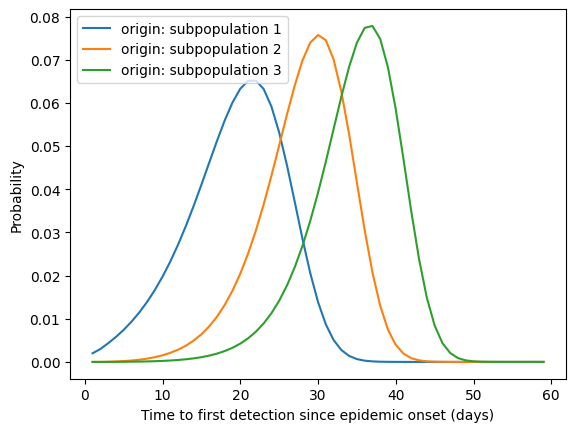

In [20]:
for label,df in detection_time.groupby('label'):
    plt.plot(df['time'],df['probability'],label=label)
plt.legend()
plt.xlabel('Time to first detection since epidemic onset (days)')
plt.ylabel('Probability')

## Cumulant extraction

Instead of extacting a full probability distribution, it is sometimes more convenient to extract the mean and variance, or in the multivariate case the mean vector and covariance matrix. To do so, we implemented the *cumulant generating function* (CGF), which is obtained by simply passing the argument ```cumulant = True``` in the object definition.

In [49]:
K = SentinelPGF(umat,mmat,smat,latency_period,infectious_period,
                post_infectious_period,nb_infectious_states,
                nb_post_infectious_states,infection,nb_microsteps,cmat1=cmat1,cmat2=cmat2,cumulant=True)

We can then work similarly as with the PGF, adding initial conditions and extracting the cumulant of interest. Here we calculate the mean (and variance) for the number of detections at a sentinel.

In [50]:
initial_state = {'nb_infectious': 10, 'nb_latent': 10}
idx = [0,1]
weight = [0.5,0.5] #each index is equiprobable
K.add_initial_conditions(idx,weight,label='origin: subpopulation 1',**initial_state)
idx = [2,3]
K.add_initial_conditions(idx,weight,label='origin: subpopulation 2',**initial_state)
idx = [4,5]
K.add_initial_conditions(idx,weight,label='origin: subpopulation 3',**initial_state)

In [56]:
#time range over which we want to measure detections
t =  list(range(0,50))

#transformation that needs to used to measure "cumulative detection" on all possible paths leading to detections
def transform(state_vars,c_):
    state_vars['cumulative detection'] *= c_
transform_dict = {max(t):[transform]}  #we measure the cumulative detection for the whole time range, explaining the max(t)

#calculate the cumulants (order 0,1,2,3) for the number of detections at the sentinel
cumulants = marginal_cumulants(K, t, transform_dict, radius=10**(-4),resolution=4)

The ```radius``` parameter is used to reduce aliasing effects caused by the underlying fast Fourier transform numerical inversion; the ```resolution``` parameter dictates how many cumulants are extracted, starting from the 0th order cumulant. These parameters should be chosen with care, please have a look [here](https://cosmo-notes.github.io/pgfunk/chapters/numerical_inversion.html) to better understand the numerical inversion procedure for generating functions and its limitations.

In [52]:
cumulants

,label,time,target,cumulant
0,origin: subpopulation 1,0,0,0.000000e+00
1,origin: subpopulation 1,0,1,0.000000e+00
2,origin: subpopulation 1,0,2,0.000000e+00
3,origin: subpopulation 1,0,3,0.000000e+00
4,origin: subpopulation 1,1,0,6.848272e-23
...,...,...,...,...
595,origin: subpopulation 3,48,3,4.426901e+02
596,origin: subpopulation 3,49,0,3.976771e-12
597,origin: subpopulation 3,49,1,1.836661e+01
598,origin: subpopulation 3,49,2,7.672334e+01


The ```target``` column serves to differentiate the different cumulants, the first cumulant ```target == 1``` is the mean and the second cumulant ```target == 2``` is the variance. Below, we plot the mean number of detections at the sentinel for each origin as a function of time.

In [54]:
df = cumulants[cumulants['target'] == 1]

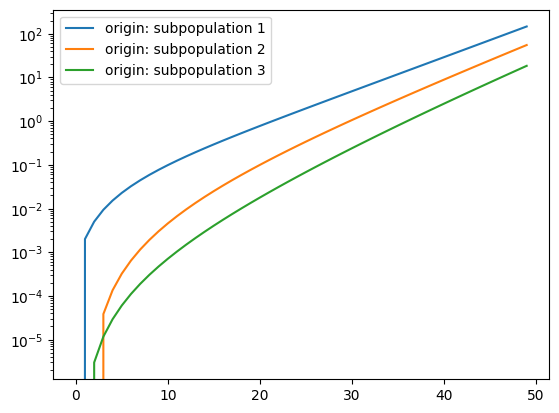

In [55]:
for label,df_ in df.groupby('label'):
    plt.semilogy(df_['time'],df_['cumulant'],label=label)
plt.legend()